RODAR O GFS PARA ALIMENTAR O WRF.
DESENVOLVER FTP DO GFS.

GFS E CORRIGIR COM IA.

OS MODELOS TENDEM



In [ ]:
!pip install chardet
!pip install PyWavelets matplotlib


In [ ]:
import numpy as np

In [ ]:
import pandas as pd
import chardet

nome_pasta = 'IRECE'
caminho_pasta = f'/content/drive/MyDrive/TCC_WIND/{nome_pasta}/INMET_NE_BA_A424_IRECE_01-01-2022_A_31-12-2022.CSV'

def detectar_codificacao(caminho_arquivo):
    with open(caminho_arquivo, 'rb') as f:
        resultado = chardet.detect(f.read())
    return resultado['encoding']

# Detecta a codificação do arquivo CSV
codificacao = detectar_codificacao(caminho_pasta)

# Tenta ler o arquivo CSV usando a codificação detectada e sniff do pandas
try:
    # Usa o sniff para detectar o delimitador
    separador = pd.read_csv(caminho_pasta, nrows=1, encoding=codificacao).columns[0]

    # Cria um DataFrame a partir do arquivo CSV
    df = pd.read_csv(caminho_pasta, skiprows=3, header=5, sep=';', encoding=codificacao)

        # Remove a coluna específica do DataFrame
    df = df.drop('Unnamed: 19', axis=1)
    # Exibe as primeiras linhas do DataFrame
    #print(df.head())
except Exception as e:
    print(f'Erro ao tentar ler o arquivo CSV: {e}')



In [ ]:
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')
# Converta a coluna 'ColunaY' para números (float)
df['VENTO, VELOCIDADE HORARIA (m/s)'] = df['VENTO, VELOCIDADE HORARIA (m/s)'].str.replace(',', '.').astype(float)
# Extraia as horas da coluna 'Horas', converta para formato timedelta e some à coluna 'Datas'
df['Hora UTC'] = pd.to_timedelta(df['Hora UTC'].str.slice(0, -6).astype(int), unit='h')
df['DataHora'] = df['Data'] + df['Hora UTC']

import numpy as np

# Criar um vetor de 0 a 24
vetor_base = np.arange(24)

# Repetir o vetor várias vezes
repeticoes = len(df['Hora UTC'])//24
df['Hora_num'] = np.tile(vetor_base, repeticoes)

df = df.dropna(subset=['VENTO, VELOCIDADE HORARIA (m/s)'])

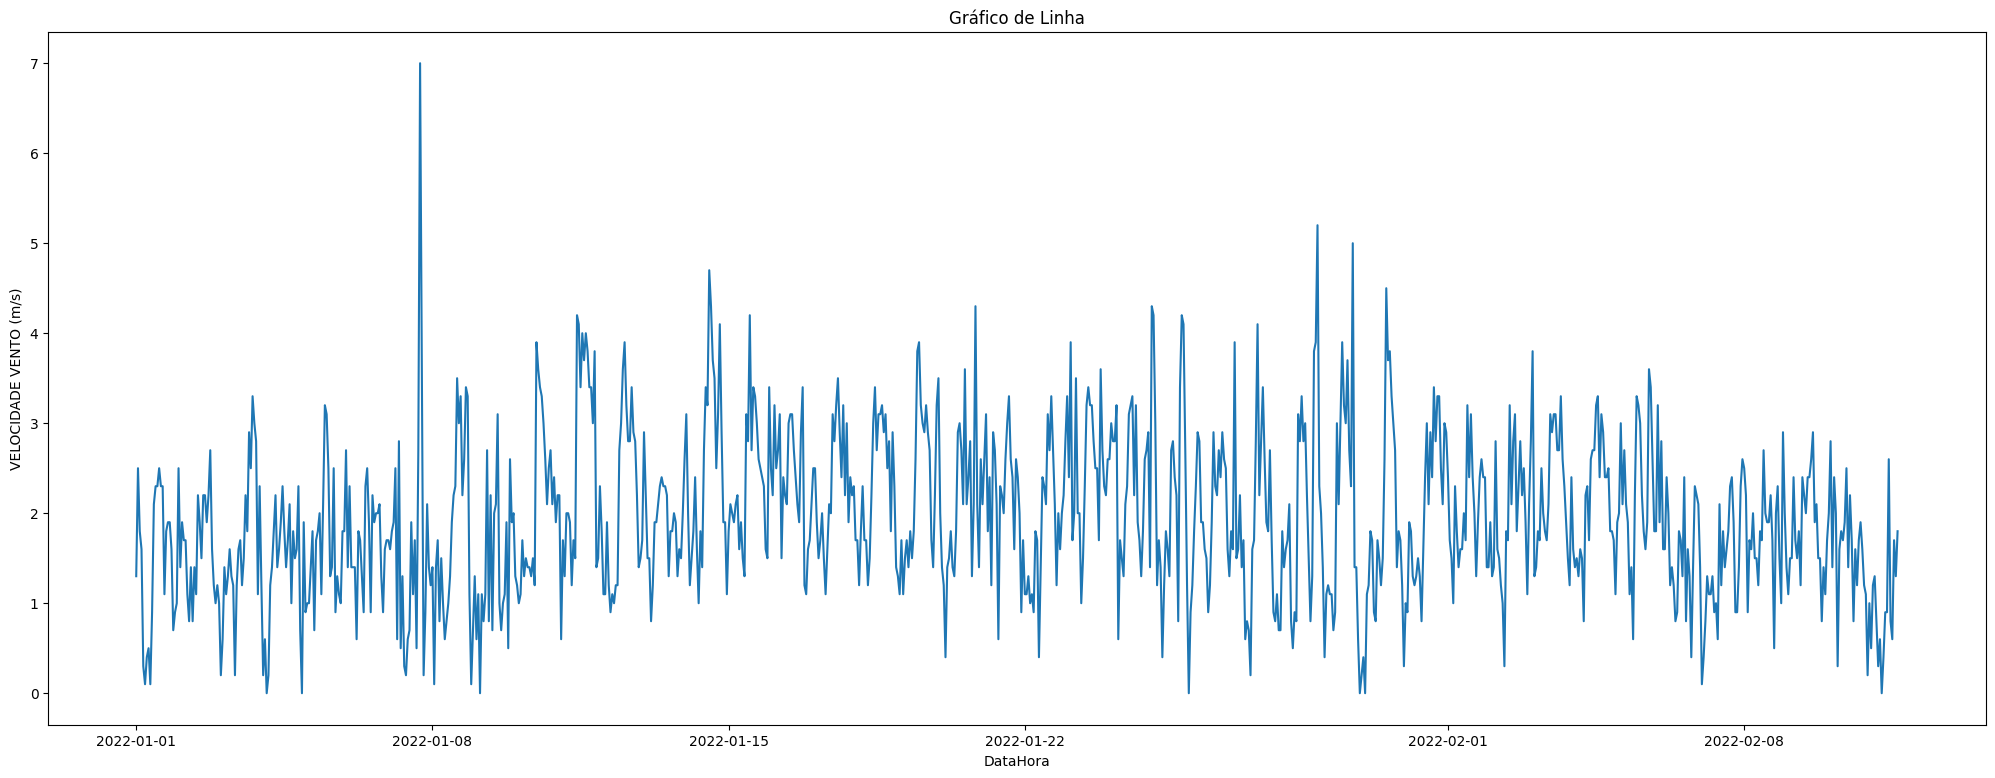

In [ ]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(figsize=(25, 9))
ax.plot(df['DataHora'][:1000], df['VENTO, VELOCIDADE HORARIA (m/s)'][:1000])
ax.set_xlabel('DataHora')
ax.set_ylabel('VELOCIDADE VENTO (m/s)')
ax.set_title('Gráfico de Linha')
plt.show()

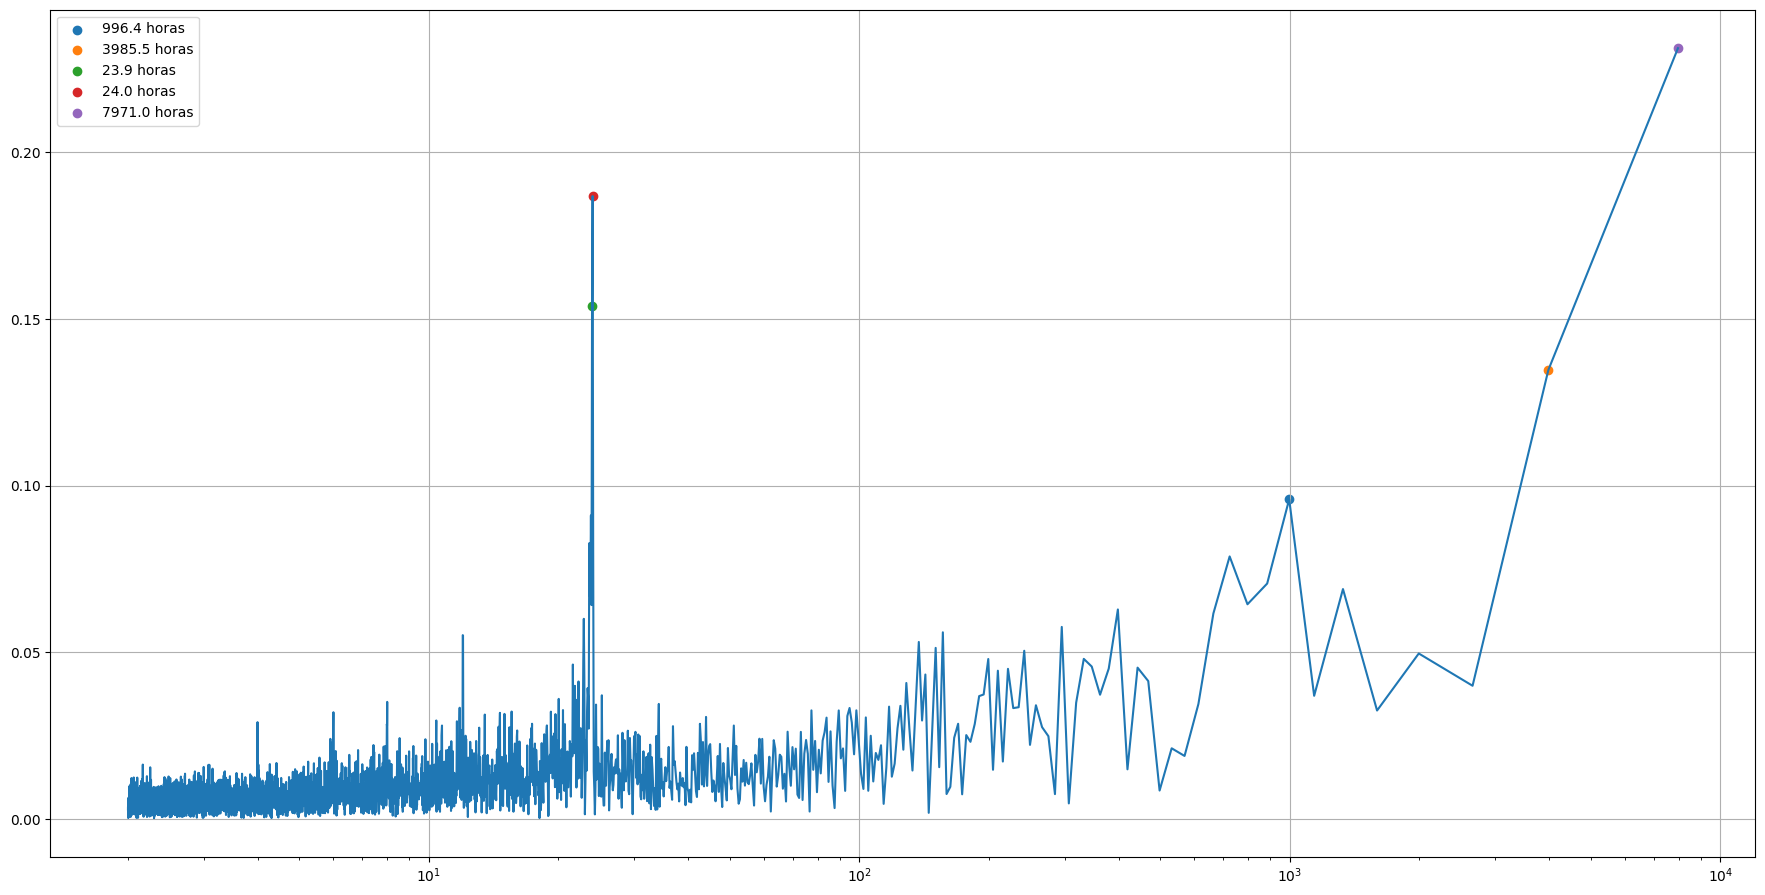

In [ ]:
# ANÁLISE DE FOURIER COM DADOS FILTRADOS PARA O ANO TODO,
# PARA IDENTIFICAÇÃO DA MAŔE APLIQUE EM APENAS UM INTERVALO DE UM MES PARA FACILITAR A IDENTIFICAÇÃO

fft1 = np.fft.ifft(df['VENTO, VELOCIDADE HORARIA (m/s)'].values)
N = len(df['DataHora'][:])
fftfreq = np.fft.fftfreq(N)
fftfreq = fftfreq
fft_theo = (np.abs(fft1))
mask = fftfreq > 0 #0.005
nmax = 5#o que esse indice faz? como encontrar periodicidades menores?
sortedmax = np.sort(fft_theo[mask])
sortedmax = sortedmax[-nmax:]
fig = plt.figure(figsize=(22,11))
#AQUI IMPORTANTE LEMBRAR DE CONVERTER A FREQUENCIA EM HZ DA ANÁLISE DE FOURIER PARA HORAS, LEMBRE 1/ PERIODO = FREQUENCIA
#ENTÃO 1/FREQUECIA = PERIODO ( QUE É O QUE QUEREMOS), DICA: A MUNDANÇA TEM QUE SER FEITA NO LABEL
#PENSE UM POUCO E VEJA ONDE MUDAR NO CÓDIGO PARA COLOCAR ESSA CONVERSÃO E VER OS VALORES NA FREQUENCIA DE HORAS
for h in range(nmax):
                locmax = np.where(fft_theo[mask][:len(fft_theo)//3]==sortedmax[h])[0][0]
                plt.scatter(1/fftfreq[mask][locmax],fft_theo[mask][locmax],marker='o',label=str(round(1/fftfreq[mask][locmax],1))+' horas')
                plt.legend()
plt.plot(1/fftfreq[mask],fft_theo[mask])
#plt.xlim(0,1000)#como deixar esse eixo melhor?
plt.xscale('log')
plt.grid()

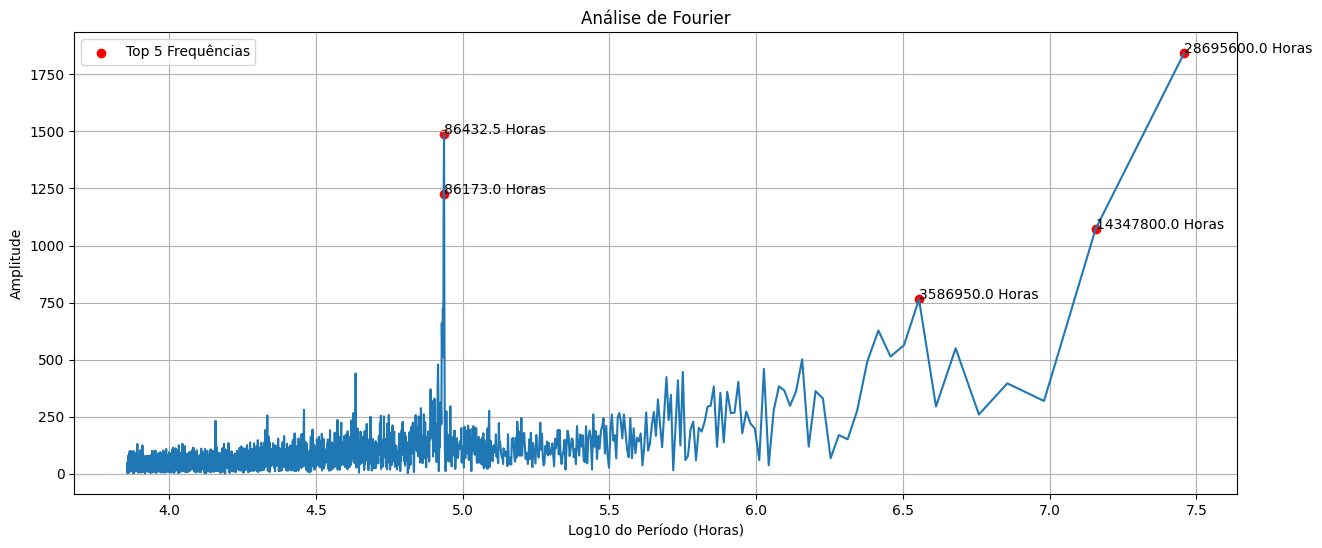

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crie uma série temporal regular com base nas datas do DataFrame
data = pd.to_datetime(df['DataHora'])
tempo = pd.date_range(start=data.min(), end=data.max(), freq='H')

# Calcule a FFT dos dados
fft_result = np.fft.fft(df['VENTO, VELOCIDADE HORARIA (m/s)'].values)
N = len(fft_result)
fft_freq = np.fft.fftfreq(N, d=(tempo[1] - tempo[0]).total_seconds())

# Ajuste do eixo x para frequência em Hz
mask = fft_freq > 0
fft_periodo_horas = np.where(fft_freq[mask] != 0, 1 / np.abs(fft_freq[mask]), np.nan)  # Use np.nan para períodos infinitos

# Obtenha as 5 principais frequências
indices_top5 = np.argsort(np.abs(fft_result[mask]))[-5:]
freq_top5 = fft_freq[mask][indices_top5]
amplitude_top5 = np.abs(fft_result[mask][indices_top5])

# Plotagem
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(np.log10(fft_periodo_horas), np.abs(fft_result[mask]))
ax.scatter(np.log10(1 / freq_top5), amplitude_top5, marker='o', color='red', label='Top 5 Frequências')

# Adicione rótulos para os pontos
for i, txt in enumerate(indices_top5):
    ax.annotate(f'{round(1 / freq_top5[i], 1)} Horas', (np.log10(1 / freq_top5[i]), amplitude_top5[i]))

# Configuração dos rótulos
ax.set_xlabel('Log10 do Período (Horas)')
ax.set_ylabel('Amplitude')
ax.set_title('Análise de Fourier')
ax.legend()

plt.grid()
plt.show()


In [ ]:
!pip install waipy

  Preparing metadata (setup.py) ... done
  Created wheel for waipy: filename=waipy-0.1.51-py3-none-any.whl size=16785 sha256=a0089f21d98467f47a89eed01d1cf948e6ebf4ab46070fd22eb7e8f8ae90359f
  Stored in directory: /root/.cache/pip/wheels/ca/c2/4b/a1c339638c96a5a307549fabd1f9558a8fc2d8ef26ea82a9d8
Successfully built waipy


In [ ]:
import waipy

Lag-1 autocorrelation = 0.73
Nr of Scales: 47
scales [2.0, 2.378414230005442, 2.8284271247461903, 3.363585661014858, 4.0, 4.756828460010884, 5.656854249492381, 6.727171322029716, 8.0, 9.513656920021768, 11.313708498984761, 13.454342644059432, 16.0, 19.027313840043536, 22.627416997969522, 26.908685288118864, 32.0, 38.05462768008707, 45.254833995939045, 53.81737057623773, 64.0, 76.10925536017415, 90.50966799187809, 107.63474115247546, 128.0, 152.2185107203483, 181.01933598375618, 215.2694823049509, 256.0, 304.4370214406966, 362.03867196751236, 430.5389646099018, 512.0, 608.8740428813932, 724.0773439350247, 861.0779292198037, 1024.0, 1217.7480857627863, 1448.1546878700494, 1722.1558584396073, 2048.0, 2435.4961715255727, 2896.309375740099, 3444.3117168792146, 4096.0, 4870.992343051145, 5792.618751480198, 6888.623433758429]


{'fig': <Figure size 4500x3000 with 5 Axes>,
 'ax_data': <Axes: title={'center': 'Vel. Vento'}, ylabel='Amplitude'>,
 'ax_cwt': <Axes: xlabel='Time', ylabel='Period'>,
 'ax_wavelet': <Axes: title={'center': '$\\psi$ (t/s) Morlet in time domain'}, xlabel='Time', ylabel='Amplitude'>,
 'ax_global_spectrum': <Axes: title={'center': 'Global Wavelet Spectrum'}, xlabel='Power'>}

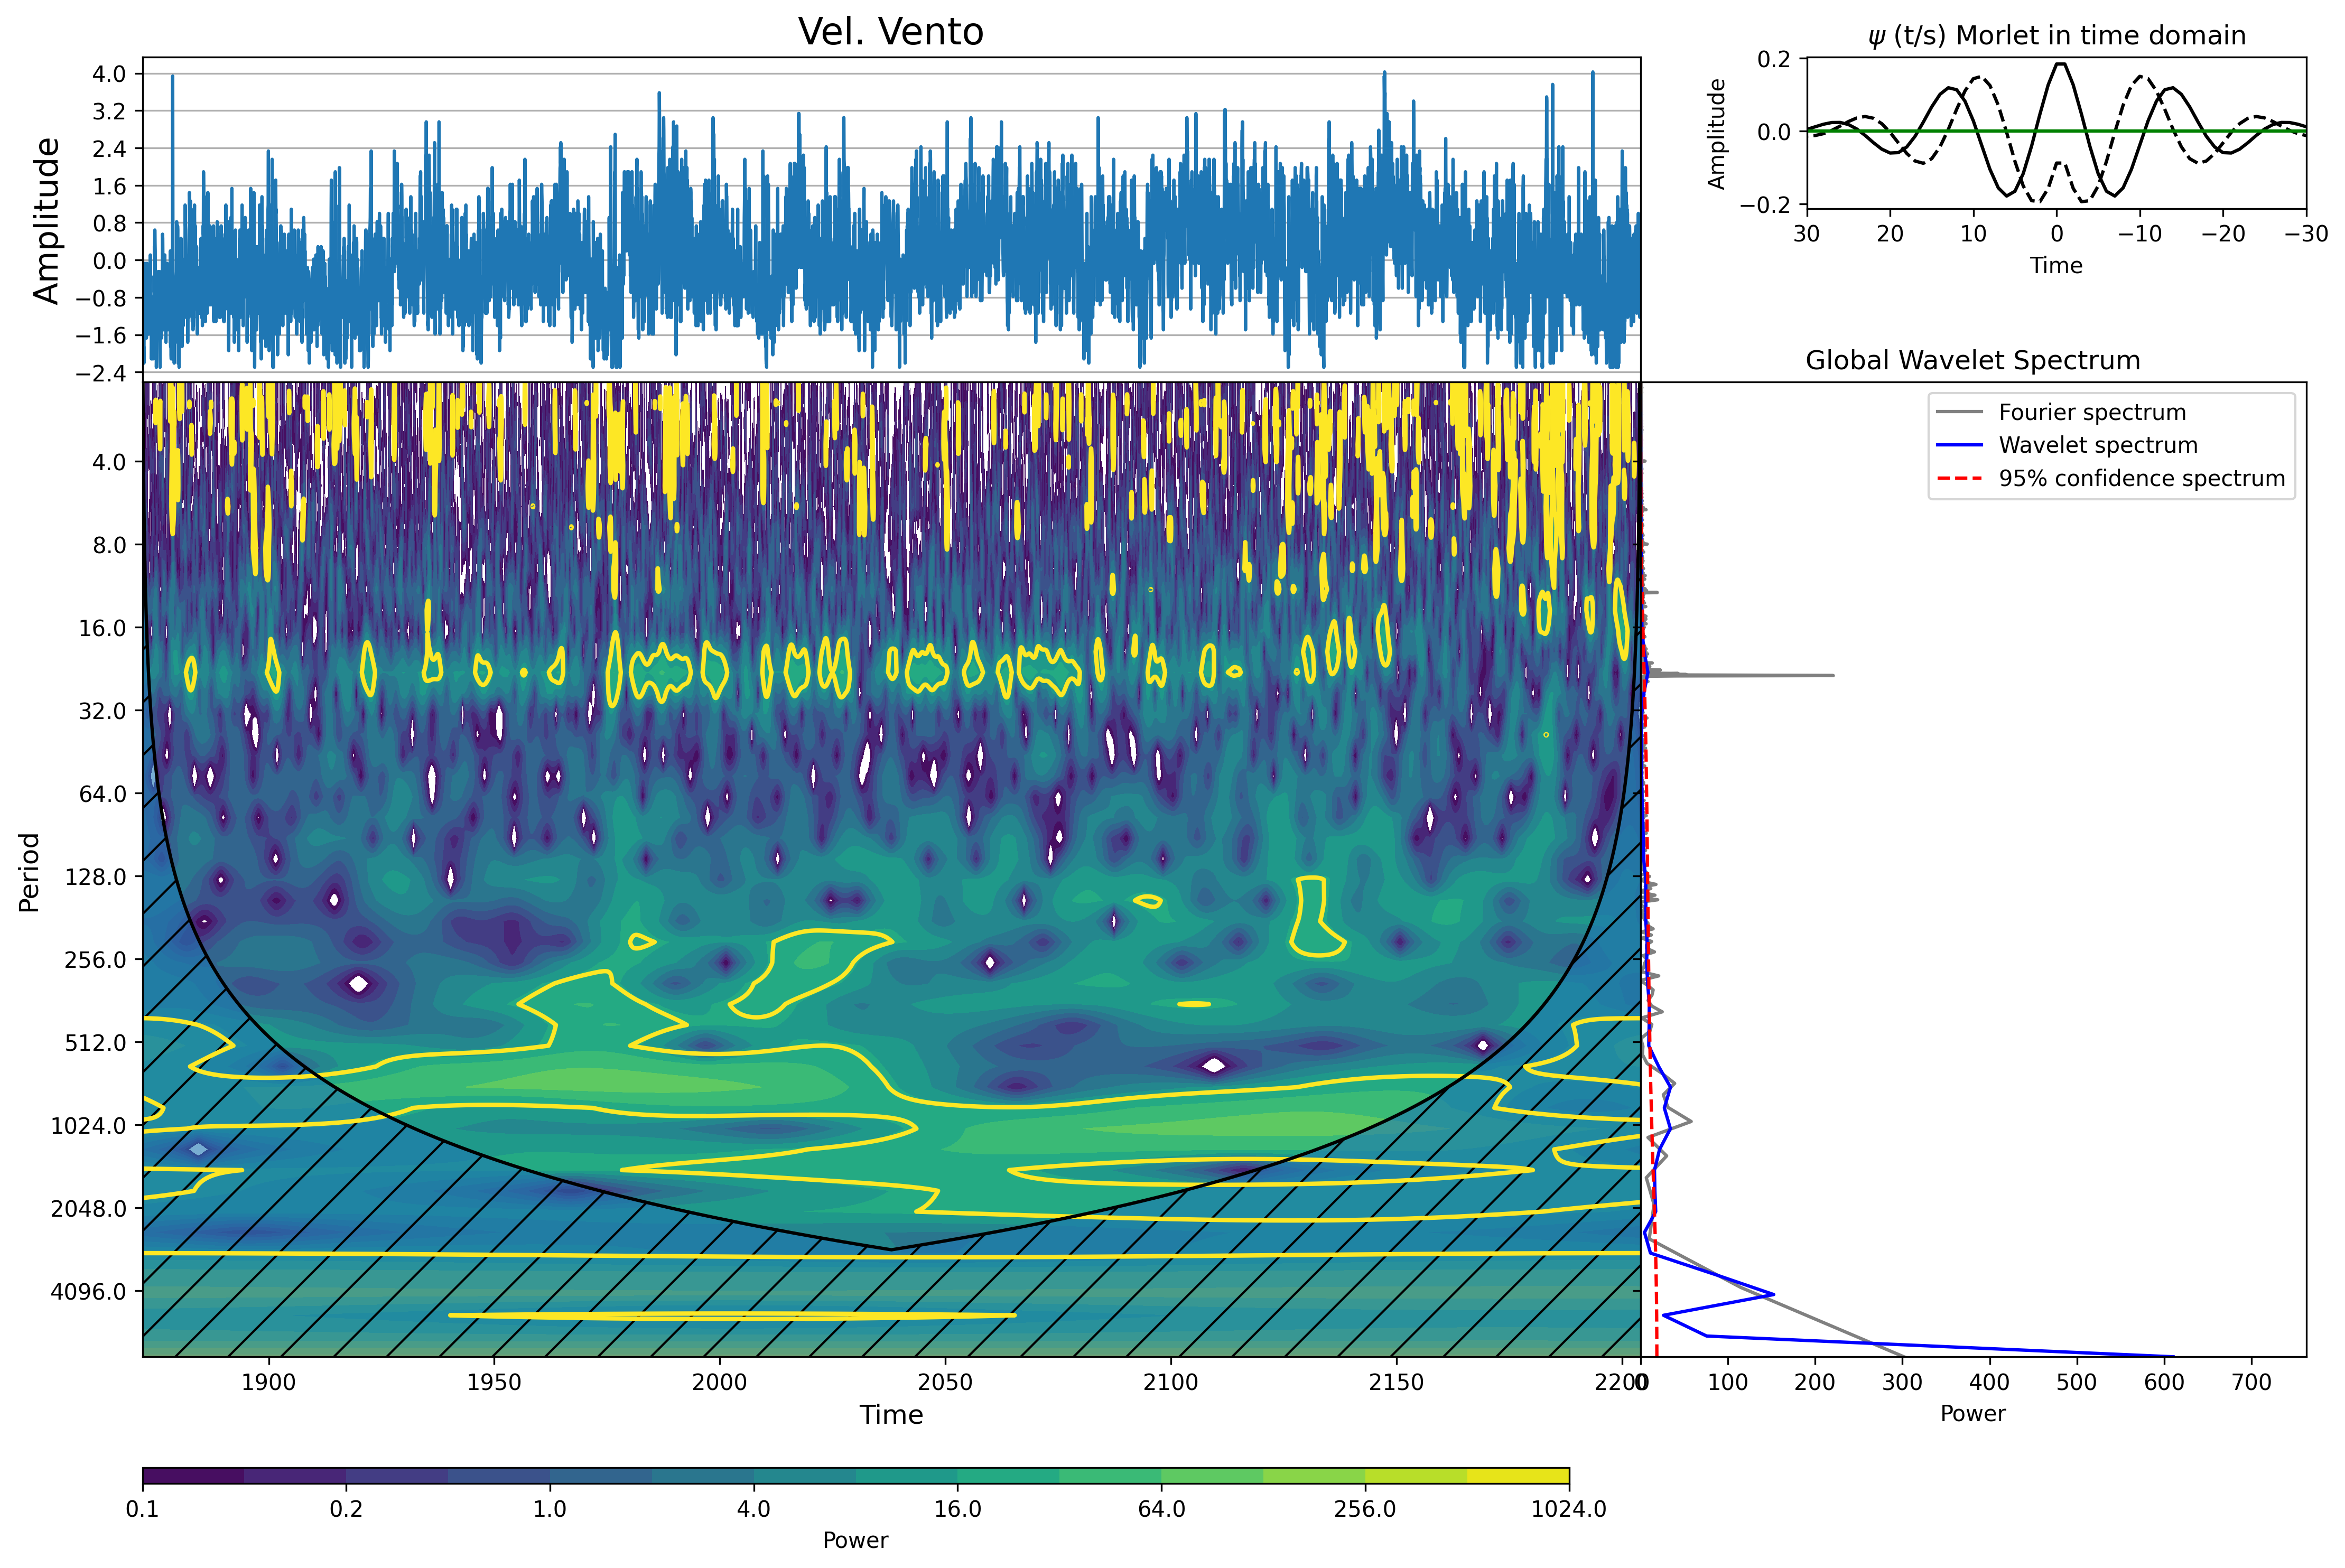

In [ ]:
#TEM QUE TER 2^n DADOS.

data = df['VENTO, VELOCIDADE HORARIA (m/s)'].values
data_norm = waipy.normalize(data)
N = data.size

t0=1872
dt=1/24
units='m/s'
label='Vel. Vento'
time = np.arange(0, N) * dt + t0

alpha = np.corrcoef(data_norm[0:-1], data_norm[1:])[0,1]
print("Lag-1 autocorrelation = {:4.2f}".format(alpha))
result = waipy.cwt(data_norm, 1, 1, 0.25, 2, 4/0.25, alpha, 6, mother='Morlet',name='x')
waipy.wavelet_plot(label, time, data_norm, 0.03125, result)

In [ ]:
#https://pycwt.readthedocs.io/en/latest/index.html
!pip install pycwt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.5/753.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.


RuntimeError: ignored

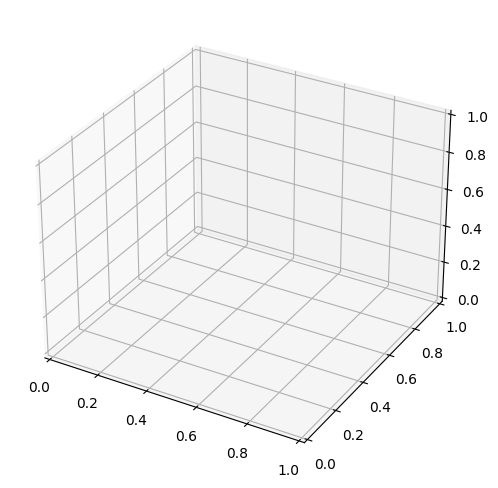

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Seus dados
dias = df['Data'].astype('datetime64[D]')
horas = df['Hora_num']
valores = df['VENTO, VELOCIDADE HORARIA (m/s)']

# Crie um gráfico de superfície vertical
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Crie a superfície sem depender da triangulação de Delaunay
superficie = ax.plot_trisurf(horas, dias, valores, cmap='viridis', shade=True, edgecolor='k', linewidth=0.1)

# Configure os rótulos dos eixos
ax.set_xlabel('Horas do Dia')
ax.set_ylabel('Dias')
ax.set_zlabel('Valores')
ax.set_title('Gráfico de Superfície Vertical')

# Adicione uma barra de cores
barra_cores = fig.colorbar(superficie, ax=ax, pad=0.1, aspect=10)

# Ajuste a rotação para melhor visualização
ax.view_init(elev=30, azim=30)

plt.show()


In [ ]:
slevel = 0.95                        # Significance level

std = data.std()                      # Standard deviation
std2 = std ** 2                      # Variance
var = (data - data.mean()) / std       # Calculating anomaly and normalizing

dj = 0.25                            # Four sub-octaves per octaves
s0 = -1 #2 * dt                      # Starting scale, here 6 months
J = -1 # 7 / dj                      # Seven powers of two with dj sub-octaves

mother = wavelet.Morlet(6.)          # Morlet mother wavelet with wavenumber=6

# The following routines perform the wavelet transform and siginificance
# analysis for the chosen data set.

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(data, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother)
power = (abs(wave)) ** 2             # Normalized wavelet power spectrum
fft_power = std2 * abs(fft) ** 2     # FFT power spectrum
period = 1. / freqs

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                        significance_level=slevel, wavelet=mother)
sig95 = (signif * np.ones((N, 1))).transpose()
sig95 = power / sig95                # Where ratio > 1, power is significant

# Calculates the global wavelet spectrum and determines its significance level.
glbl_power = std2 * power.mean(axis=1)
dof = N - scales                     # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                       significance_level=slevel, dof=dof, wavelet=mother)